# Bootstrapping ML Performance

## 0. Env

#### Imports

In [13]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
import geohash2
import plotly.graph_objects as go
import plotly.express as px
from typing import List, Optional

In [21]:
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(90)

polars.config.Config

#### Constants

In [3]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [4]:
TRAIN_TEST_SPLIT_PERCENT = 80  # (max 100%)
MODEL_TARGET = "price_log10"
GEOHASH_PRECISION = 6

In [6]:
MIAMI_MAP_BOUNDS = {
    "west": -80.674245,
    "east": -79.989138,
    "south": 23.003683,
    "north": 27.024563,
}

#### Helper Functions

In [7]:
def plot_geo_df(
    geo_df: pl.DataFrame,
    colorby_column: str,
    colorbar_tickvals: List[int],
    colorbar_ticktext: List[str],
    plot_title: str,
    range_color: Optional[List[int]] = None,
):
    df_sample = geo_df.sample(fraction=1, shuffle=True)
#     range_color = [int(geo_df[colorby_column].min()), int(geo_df[colorby_column].max()) + 1] if not range_color else range_color
    range_color = [geo_df[colorby_column].min(), int(geo_df[colorby_column].max()) + 1] if not range_color else range_color
    fig = px.scatter_mapbox(
        data_frame=df_sample,
        lat="latitude",
        lon="longitude",
        color=colorby_column,
#         range_color=range_color,
        size=[.01] * len(df_sample),
        size_max=2.4
    )
    fig.update_layout(
        mapbox_style="carto-positron",
        margin={"r":0, "t":0, "l":0, "b":0},
        mapbox_bounds=MIAMI_MAP_BOUNDS,
        coloraxis_colorbar={
            "title": plot_title,
            "tickvals": colorbar_tickvals,
            "ticktext": colorbar_ticktext,
        },
    )
    fig.write_image(os.path.join(images_dir, f"miami-{plot_title.lower().replace(' ', '-')}.png"))

## 1. Load Data

In [25]:
# Data taken from https://www.openml.org/search?type=data&id=43093
df = (
    pl.read_csv("../data/miami-housing.csv")
    .with_columns([
        pl.col("SALE_PRC").alias("price"),
        pl.col(["LATITUDE", "LONGITUDE"]).name.to_lowercase()
    ])
    .with_columns([
        pl.col("price").log10().name.suffix("_log10")
    ])
    .with_row_index(name="index")
    .select([
        pl.col("index").mod(10).lt(TRAIN_TEST_SPLIT_FRACTION * 10).alias("is_train"),
        "latitude",
        "longitude",
        "price",
        "price_log10"
    ])
)

## 2. Brief EDA

#### Distribution of Prices

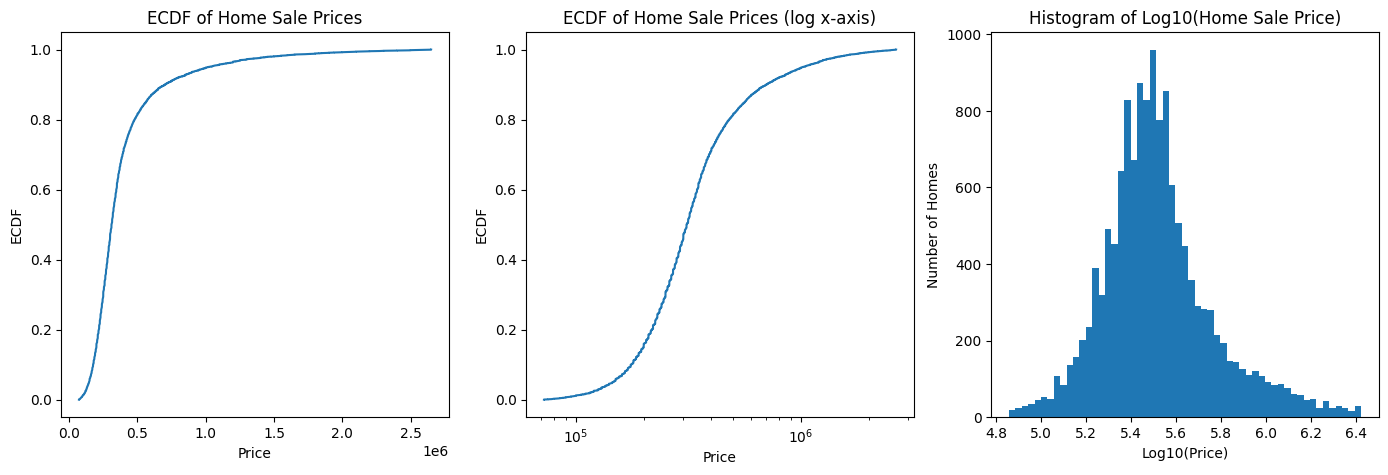

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Home Sale Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Home Sale Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Homes")
ax3.set_title("Histogram of Log10(Home Sale Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-home-sale-price.png"))

#### Distribution over Space

In [12]:
plot_geo_df(
    df,
    colorby_column="price_log10",
    colorbar_tickvals=[1, 2, 3, 4, 5, 6, 7, 8],
    colorbar_ticktext=["$10", "$100", "$1K", "$10K", "$100K", "$1M", "$10M", "$100M"],
    plot_title="Home Sale Price",
)

#### Correlation

In [13]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.721232,0.047701
0.721232,1.0,0.195274
0.047701,0.195274,1.0


## 3. Results

In [30]:
MODEL_PERFORMANCE_LIST = []

In [31]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]
X_train = df.filter(pl.col("is_train"))
y_train = df.filter(pl.col("is_train"))
X_test = df.filter(~pl.col("is_train"))
y_test = df.filter(~pl.col("is_train"))

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(
        X_train.select(MODEL_FEATURE_LIST),
        y_train.select(MODEL_TARGET)
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = root_mean_squared_error(y_test.select(MODEL_TARGET), y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    MODEL_PERFORMANCE_LIST.append(model_result)

### 3.5 Summary

In [32]:
results_feature_set_order = [
    "raw_lat_lon",
#     "spatial_density",
#     "geohash_target_encoding",
#     "all_features"
]

In [33]:
results_summary_df = (
    pd.DataFrame
    .from_records(MODEL_PERFORMANCE_LIST)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)
results_summary_df.columns.name = None
results_summary_df.index.name = None

In [34]:
print(
    results_summary_df
    .loc[results_feature_set_order, :]
    .style
    .format("{:.5f}")
    .background_gradient(vmin=0.1, vmax=0.2, axis=None)
    .to_html()
)

<style type="text/css">
#T_fbc5b_row0_col0 {
  background-color: #023858;
  color: #f1f1f1;
}
#T_fbc5b_row0_col1 {
  background-color: #eee9f3;
  color: #000000;
}
</style>
<table id="T_fbc5b">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_fbc5b_level0_col0" class="col_heading level0 col0" >ridge regression</th>
      <th id="T_fbc5b_level0_col1" class="col_heading level0 col1" >xgboost</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_fbc5b_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>
      <td id="T_fbc5b_row0_col0" class="data row0 col0" >0.24179</td>
      <td id="T_fbc5b_row0_col1" class="data row0 col1" >0.11113</td>
    </tr>
  </tbody>
</table>

